 # golub dataset

In [1]:
# install.packages("binom") # Installed from R studio as needs compilation
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("cancerclass")

In [2]:
library("binom") 
library("evaluomeR")
library("cancerclass")
library("dplyr")
library("caret")

options(scipen=10)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

# Table of contents
* [Dataset](#dataset)
    * [Removing correlated](#correlated)
    * [Top 200](#top)
    * [evaluomeR](#evaluomer)
* [Clest](#clest)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
load("leukemia.RData")
golub = as.data.frame(leukemia)

In [4]:
#library("evaluomeR") 
#library("cancerclass")

#load("leukemia.RData")
#golub = as.data.frame(leukemia)
#golub["Class"] = NULL
#golub["sample"] = NULL
#golub["type"] = NULL
#golub["FAB"] = NULL
#golub["gender"] = NULL

#colnames(golub)[colnames(golub) == 'Case'] <- 'Description'

#seed = 13606
#k.range=c(3,10)
#cbi = "clara"
#stab_range = stabilityRange(data=golub, k.range=k.range, 
#                            bs=100, seed=seed,
#                            all_metrics=TRUE,
#                            cbi=cbi)
#stab = standardizeStabilityData(stab_range)

# Qual
#qual_range = qualityRange(data=golub, k.range=k.range, 
#                            all_metrics=TRUE, seed=seed,
#                            cbi=cbi)

#qual = standardizeQualityData(qual_range)
# K opt
#k_opt = getOptimalKValue(stab_range, qual_range, k.range= k.range)
#optimal_k = k_opt$Global_optimal_k
#optimal_k_str = paste0("k_", optimal_k)
#print(paste0("Optimal k: ", optimal_k))

In [5]:
head(golub)

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


In [6]:
#unique(golub["Class"])

In [7]:
# https://rdrr.io/bioc/cancerclass/man/GOLUB.html

In [8]:
# data(GOLUB1)
# golub = as.data.frame(rdata_golub)

In [9]:
head(golub)
print(paste0("Rows: ", nrow(golub)))
print(paste0("Columns: ", ncol(golub)))
# En el artículo dice: The data are then summarized by a 72 × 3,571

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


[1] "Rows: 72"
[1] "Columns: 102"


In [10]:
#golub["class"] = NULL
golub["Class"] = NULL # leukemia
golub["sample"] = NULL
golub["type"] = NULL
golub["FAB"] = NULL
golub["gender"] = NULL
print(paste0("Rows: ", nrow(golub)))
print(paste0("Columns: ", ncol(golub)))
#golub["labels"] = rownames(golub)
#golub = golub[ , c("labels", names(golub)[names(golub) != "labels"])] 

[1] "Rows: 72"
[1] "Columns: 101"


In [11]:
head(golub)

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000


# Removing correlated <a class="anchor" id="correlated"></a>

In [12]:
data = golub[-1]
R = cor(data)
head(R)

,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,D88422_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
AFFX.HUMRGE.M10098_5_at,1.00000000,0.94528825,0.940680900,0.77912853,-0.1973053,0.020456906,-0.1096624,-0.01383022,-0.016918622,-0.1411501,...,0.14065855,-0.02998448,0.21601689,-0.02605452,-0.330429874,0.01579724,-0.2972520,-0.070312138,-0.21883293,0.015992406
AFFX.HUMRGE.M10098_M_at,0.94528825,1.00000000,0.910579713,0.71505370,-0.2134307,-0.035661949,-0.1675192,-0.03848112,0.056532531,-0.1995248,...,0.11476015,-0.13127374,0.18020996,-0.07453643,-0.235098965,-0.09126448,-0.2673512,-0.141429954,-0.26065292,-0.040604229
AFFX.HUMRGE.M10098_3_at,0.94068090,0.91057971,1.000000000,0.78440879,-0.2103221,0.004372542,-0.1382389,-0.07123307,-0.006921601,-0.2050484,...,0.22623819,-0.06758595,0.30290886,-0.04552536,-0.287973093,-0.02285115,-0.3739390,-0.116550351,-0.30384555,-0.063379185
AFFX.M27830_5_at,0.77912853,0.71505370,0.784408790,1.00000000,-0.1259413,-0.058320081,-0.2053630,-0.09539274,0.191117767,-0.2962061,...,0.07777391,0.01270773,0.16755869,-0.16011183,-0.152058167,0.04371082,-0.1734089,-0.071983122,-0.33546790,-0.092884086
D13639_at,-0.19730530,-0.21343065,-0.210322067,-0.12594134,1.0000000,0.214746419,-0.2134899,-0.06713339,0.088769297,-0.1301940,...,-0.18625093,0.15779702,-0.25359480,0.09809683,0.088825194,0.22350988,0.4512396,0.200613737,-0.02989658,0.001768725
D83735_at,0.02045691,-0.03566195,0.004372542,-0.05832008,0.2147464,1.000000000,0.1859050,0.18106050,-0.243976369,0.1595494,...,0.16543140,0.04991622,-0.02040268,0.28615603,-0.002396266,0.13131286,0.1734750,-0.007277627,0.35960233,0.164954817


In [13]:
cor_metrics = findCorrelation(R, cutoff = 1, verbose = FALSE, names=TRUE)
length(cor_metrics)

[1] 0

# Top 200 <a class="anchor" id="top"></a>

In [14]:
variance = sort(sapply(golub[-1], var,na.rm = TRUE), decreasing = TRUE)  # Sorted gene variance
gene_var = as.data.frame(variance)
gene_var["gene"] = rownames(gene_var)
head(gene_var)

,variance,gene
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [15]:
top_number = 100
top_genes = gene_var[c(1:top_number), ]
head(top_genes)

,variance,gene
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [16]:
gene_list = as.list(top_genes["gene"])

In [17]:
top_gene_list = unlist(setdiff(gene_list, names(golub)))
top_gene_list

[1] "X82240_rna1_at"          "M27891_at"              
  [3] "M26311_s_at"             "AFFX.HUMRGE.M10098_5_at"
  [5] "Y00787_s_at"             "M84526_at"              
  [7] "M19507_at"               "D88270_at"              
  [9] "M63438_s_at"             "M28130_rna1_s_at"       
 [11] "AFFX.HUMRGE.M10098_M_at" "M12886_at"              
 [13] "M91036_rna1_at"          "AFFX.HUMRGE.M10098_3_at"
 [15] "AFFX.M27830_5_at"        "X00437_s_at"            
 [17] "M21005_at"               "M87789_s_at"            
 [19] "M58459_at"               "M11722_at"              
 [21] "U01317_cds4_at"          "M21305_at"              
 [23] "M27783_s_at"             "L33930_s_at"            
 [25] "J04164_at"               "J04456_at"              
 [27] "X58529_at"               "U89922_s_at"            
 [29] "M21119_s_at"             "M25079_s_at"            
 [31] "M89957_at"               "Z83821_cds2_at"         
 [33] "M57710_at"               "M38690_at"              
 [35] "M57466_s_at"             "X05908_at"              
 [37] "X77737_at"               "M34516_at"              
 [39] "M91438_at"               "M96326_rna1_at"         
 [41] "U05259_rna1_at"          "X76223_s_at"            
 [43] "K01911_at"               "D88422_at"              
 [45] "U05255_s_at"             "X04500_at"              
 [47] "HG3576.HT3779_f_at"      "X95735_at"              
 [49] "X64072_s_at"             "D83735_at"              
 [51] "D83920_at"               "M21904_at"              
 [53] "J03909_at"               "AF000424_s_at"          
 [55] "Z23090_at"               "D13639_at"              
 [57] "J04102_at"               "U57341_at"              
 [59] "M15395_at"               "Z84721_cds2_at"         
 [61] "M38591_at"               "D87433_at"              
 [63] "U46499_at"               "X17042_at"              
 [65] "M63573_at"               "U09770_at"              
 [67] "U20734_s_at"             "M94345_at"              
 [69] "M23178_s_at"             "M11717_rna1_at"         
 [71] "M57731_s_at"             "J03077_s_at"            
 [73] "HG987.HT987_at"          "U02687_at"              
 [75] "L08895_at"               "M12759_at"              
 [77] "M34996_s_at"             "M13560_s_at"            
 [79] "M74719_at"               "X59871_at"              
 [81] "M92934_at"               "U23852_s_at"            
 [83] "U50743_at"               "U60644_at"              
 [85] "U10485_at"               "Z22548_at"              
 [87] "L20971_at"               "M33882_at"              
 [89] "J04615_at"               "X62744_at"              
 [91] "Z69881_at"               "M16279_at"              
 [93] "M21624_at"               "U02020_at"              
 [95] "M16336_s_at"             "L19686_rna1_at"         
 [97] "X65965_s_at"             "X03934_at"              
 [99] "M28826_at"               "M30703_s_at"

In [18]:
top_golub = golub[, top_gene_list]
top_golub["labels"] = rownames(top_golub)
top_golub = top_golub[ , c("labels", names(top_golub)[names(top_golub) != "labels"])] 

In [19]:
head(top_golub)

labels,X82240_rna1_at,M27891_at,M26311_s_at,AFFX.HUMRGE.M10098_5_at,Y00787_s_at,M84526_at,M19507_at,D88270_at,M63438_s_at,...,Z69881_at,M16279_at,M21624_at,U02020_at,M16336_s_at,L19686_rna1_at,X65965_s_at,X03934_at,M28826_at,M30703_s_at
1,4.16170,2.48144,2.00000,4.16250,2.52244,2.0000,2.0000,3.29336,3.75143,...,3.24699,3.48841,2.43457,2.24551,2.00000,2.89487,2.83059,2.79449,2.00000,2
2,2.00000,3.13290,3.64856,2.78888,3.72795,2.0000,2.0000,2.29667,3.68646,...,3.30428,4.01932,4.07185,3.05690,3.31513,3.86094,3.40926,3.88434,2.00000,2
3,2.00000,2.40483,2.88930,3.75351,2.47857,2.0000,2.0000,2.76268,2.00000,...,3.55096,3.97211,2.26007,2.06070,3.56384,3.79616,2.52763,4.05312,3.94379,2
4,3.71659,2.00000,2.19590,3.68574,2.38202,2.0000,2.0000,3.68851,2.00000,...,2.91803,3.17406,2.00000,2.00000,2.00000,2.79449,2.43457,2.67578,2.00000,2
5,3.77772,2.00000,3.33746,3.10857,2.00000,2.4624,2.9722,3.52930,2.83696,...,3.17493,3.67596,2.00000,2.33646,2.00000,3.78810,2.56820,2.53782,2.00000,2
6,2.00000,3.06744,3.20737,3.61784,2.33244,2.0000,2.0000,2.00000,2.00000,...,3.41597,3.94655,2.00000,2.00000,3.50947,3.55425,2.50651,3.85485,3.69522,2


# evaluomeR K analysis

In [20]:
seed = 13606
k.range=c(3,10)
cbi = "clara"
top_golub = golub
colnames(top_golub)[colnames(top_golub) == 'Case'] <- 'Description'
# Stab
stab_range = stabilityRange(data=top_golub, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
stab = standardizeStabilityData(stab_range)

# Qual
qual_range = qualityRange(data=top_golub, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi)
qual = standardizeQualityData(qual_range)

# K opt
k_opt = getOptimalKValue(stab_range, qual_range, k.range= k.range)
optimal_k = k_opt$Global_optimal_k
optimal_k_str = paste0("k_", optimal_k)
print(paste0("Optimal k: ", optimal_k))


Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
Processing metric: all_metrics

	Maximum stability and quality values matches the same K value: '3'



[1] "Optimal k: 3"


In [21]:
print(paste0("W/ ", cbi))
stab
qual
print(paste0("Stab in k=", optimal_k,": ", stab[optimal_k_str]))
print(paste0("Qual in k=", optimal_k,": ", qual[optimal_k_str]))

[1] "W/ clara"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.7853092,0.7537019,0.6352238,0.5512476,0.5027411,0.5753578,0.6026215,0.6276503


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.2320141,0.1299018,0.09750963,0.08118129,0.07984548,0.1031934,0.09457494,0.09856581


[1] "Stab in k=3: 0.78530918036429"
[1] "Qual in k=3: 0.23201412622582"


# Clusters

In [22]:
individuals_per_cluster = function(qualityResult) {
  qual_df = as.data.frame(assay(qualityResult))


  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "InCluster")

  return(individuals_in_cluster)
}

In [23]:
qual_cbi = qualityRange(data=top_golub, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi)
cluster_individuals = individuals_per_cluster(assay(qual_cbi[optimal_k_str]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
standardizeQualityData(qual_cbi)
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("---")
}


Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


[1] "CBI: clara - k: 3"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.2320141,0.1299018,0.09750963,0.08118129,0.07984548,0.1031934,0.09457494,0.09856581


[1] "Cluster 1 : B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,B29,B30,B31,B32,B33,B34,B35,B36,B37,B38"
[1] "---"
[1] "Cluster 2 : T1,T2,T3,T4,T5,T6,T7,T8"
[1] "---"
[1] "Cluster 3 : B10,AML1,AML2,AML3,AML4,AML5,AML6,AML7,AML8,AML9,AML10,AML11,T9,AML12,AML13,AML14,AML15,AML16,AML17,AML18,AML19,AML20,AML21,AML22,AML23,AML24,AML25"
[1] "---"


# Clest <a class="anchor" id="clest"></a>

In [24]:
#top_golub_copy = top_golub
#top_golub[-1]

In [25]:
# -- Clest
#golub_clest = Clest(as.matrix(top_golub_copy[-1]), maxK = 6, alpha=0, B=3, B0=10, beta = 0.01, nstart=100,pca=FALSE,L1=3,silent=TRUE);

In [26]:
#names(golub_clest)
#golub_clest$observedCERs
#golub_clest$K

In [27]:
#?Clest

# PCA <a class="anchor" id="pca"></a>

In [28]:
#PCA
print(length(cluster_individuals$InCluster))
print(nrow(top_golub))
top_golub["inCluster"] = as.numeric(cluster_individuals$InCluster)
unique(cluster_individuals$InCluster)

[1] 72
[1] 72


[[1]]
[1] "1"

[[2]]
[1] "2"

[[3]]
[1] "3"

In [29]:
pca_matrix = top_golub %>% select(-Description, -inCluster)
head(pca_matrix)

AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,D88422_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,2.20683,...,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,2.76938,...,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,2.31597,...,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,2.00000,...,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,2.52763,...,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,2.30103,...,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000


In [30]:
pca_result <- prcomp(pca_matrix, scale. = TRUE)

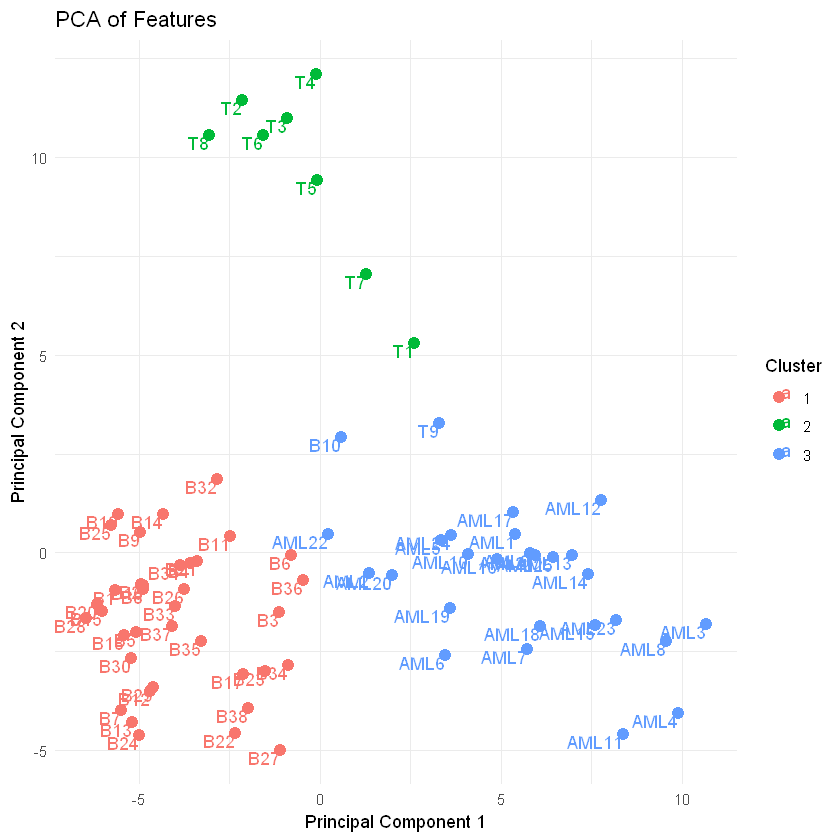

In [31]:
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_golub$inCluster)
pca_df$Individual <- top_golub$Description

# Plot PCA results

ggplot2::ggplot(pca_df, ggplot2::aes(x = PC1, y = PC2, color = Cluster, label = Individual)) +
  ggplot2::geom_point(size = 3) +
  ggplot2::geom_text(vjust = 1, hjust = 1) +
  ggplot2::labs(title = "PCA of Features",
       x = "Principal Component 1",
       y = "Principal Component 2") +
  ggplot2::theme_minimal()

# Sensitivity <a class="anchor" id="sensitivity"></a>

In [32]:
library("MLmetrics")


Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:RSKC':

    Sensitivity

The following object is masked from 'package:base':

    Recall



In [33]:
top_golub["Class"] = as.data.frame(leukemia)["Class"]
head(top_golub)[, c("Description", "Class")]

Description,Class
B1,B
T1,T
T2,T
B2,B
B3,B
T3,T


In [34]:
# Define levels and their corresponding numbers
# Order is important
# kmeans k = 4
#level_mapping <- c("M" = 1, "T" = 2, "MM" = 3, "B" = 4)
# clara k = 3
level_mapping <- c("B" = 1, "T" = 2, "M" = 3)


In [35]:
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
top_golub["Class_n"] = lapply(top_golub["Class"], map_strings_to_numbers)
top_golub[, c("Description", "Class", "Class_n")]

Description,Class,Class_n
B1,B,1
T1,T,2
T2,T,2
B2,B,1
B3,B,1
T3,T,2
B4,B,1
B5,B,1
T4,T,2
T5,T,2


In [36]:
# Getting a vector of clusters
actual = as.factor(as.vector(unlist(top_golub["Class_n"])))
predicted <- factor(as.vector(unlist(top_golub["inCluster"])))

print("actual")
actual
print("predicted")
predicted

[1] "actual"


[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
Levels: 1 2 3

[1] "predicted"


[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 3 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
Levels: 1 2 3

In [37]:
sens <- Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 97.37%"


# CER <a class="anchor" id="cer"></a>

In [38]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 3.76%"
